In [1]:
import numpy as np
from itertools import product

class SRModel(object):
    '''
        SR model based on Experiment 2 KTH, SR, AM SPI Mechanism
    
    '''
    def __init__(self, **kwargs):
        
        self.numPlayers = 4
        self.value = np.array([200, 250, 320])
        self.cost = np.array([130, 80, 10])
        
        # number of individual actions
        self.numiActions = 9
        self.buyerActions = np.array(list(product([0, 1, 2], repeat=2)))
        self.sellerActions = np.array(list(product([0, 1, 2], repeat=2)))
        self.buyerbrotherActions = np.array(list(product([0, 1, 2], repeat=2)))
        self.sellerbrotherActions = np.array(list(product([0, 1, 2], repeat=2)))
        
        self.memory = kwargs.get('memory', 0)
        self.true_value_index = kwargs.get('true_value',2)
        self.true_cost_index = kwargs.get('true_cost',2)
        self.trueValue = self.value[self.true_value_index]
        self.trueCost = self.cost[self.true_cost_index]
        
        self.delta = kwargs.get('delta',0.95)
        
        self.reward = 300
        
        self.penalty = -300

        self.eps = kwargs.get('eps',0.5)
        
        self.buyerInvestment = 0
        self.sellerInvestment = 0       
#         self.trueValue = self.init_TrueValue(self.sellerInvestment)
#         self.trueCost = self.init_TrueCost(self.buyerInvestment)
        
        
        self.numActions = self.numiActions ** self.numPlayers
        self.numStates = self.numiActions ** (self.numPlayers * self.memory)
        
        self.indexActions = self.init_indexActions()
        self.Prices = self.init_Prices()
        self.Profits,self.Penalty = self.init_Profits()
#         self.Profits = self.Profits*0.002
#         self.Penalty = self.Penalty*0.002

        # QL

        self.lengthStates = self.numPlayers * self.memory
        self.lengthStrategies = self.numPlayers * self.numStates
        
        self.Q = self.init_Q()

        self.cActions = self.init_cActions()
        
        
    def init_indexActions(self):
        
        indexActions = []
        for i in range(self.numActions):
            
            indexActions.append(self.convertNumberBase(i, self.numiActions, self.numPlayers))
            
        indexActions = np.array(indexActions)
        
        return indexActions

    def init_TrueValue(self, i):
        if i == 0:
            return 200
        elif i == 25:
            return 250
        else:
            return 320

    def init_TrueCost(self, i):
        if i == 0:
            return 130
        elif i == 25:
            return 80
        else:
            return 10
    
    def init_Prices(self):
        
        pricesArray = np.zeros((3, 3))
        for cb in range(0, 3):
            for vs in range(0, 3):
                
                # (vs-200) - (130-cb) + 165
                
                pricesArray[cb][vs] = (self.value[vs] - 200) - (130 - self.cost[cb]) + 165
                
        return pricesArray

    
    def init_Profits(self):
        Profits = np.zeros((2,self.numActions, self.numPlayers))
        Penalty = np.zeros((2,self.numActions, self.numPlayers))        
        Actions = np.zeros((self.numActions, 8))
        
        for i in range(self.numActions):
            b = int(self.indexActions[i][0])
            b_b = int(self.indexActions[i][1])
            s = int(self.indexActions[i][2])
            s_b = int(self.indexActions[i][3])
            
            vb, cb = self.buyerActions[b]
            vs, cs = self.sellerActions[s]
            vb_b, cb_b = self.buyerbrotherActions[b_b]
            vs_b, cs_b = self.sellerbrotherActions[s_b]
            
            penalb = 0
            penals = 0
            penalb_b = 0
            penals_b = 0
            
            pb = 0
            ps = 0
            pb_b = 0
            ps_b = 0
            
            Actions[i] = vb, cb, vb_b, cb_b, vs, cs, vs_b, cs_b
                
                # profit for buyer: true value - price - investment_buyer
            pb_na = self.trueValue - self.Prices[cb][vs] - self.buyerInvestment

            # profit for seller: price - true cost - investment_seller
            ps_na = self.Prices[cb][vs] - self.trueCost - self.sellerInvestment    
            
            pb_b_na = 0
            ps_b_na = 0
            
            
            if (vb == vs) and (cb == cs):
                # if all report coincide  
                pb = pb_na
                ps = ps_na
                pb_b = pb_b_na
                ps_b = ps_b_na
            
                
            elif (vb != vs) and (cb == cs):
                # only the value reports differ
                # buyer enters into arbitration stage
                
                if vb_b == 0:
                    # no_trade
                    pb = 0 - self.buyerInvestment
                    ps = 0 - self.sellerInvestment
                    pb_b = pb
                    ps_b = ps
                    
                elif vb_b == 1:
                    pb = 0.5 * 0 + 0.5 * (self.trueValue - 205) - self.buyerInvestment
                    ps = 0.5 * 0 + 0.5 * (205 - self.trueCost) - self.sellerInvestment
                    pb_b = pb
                    ps_b = ps
                    
                else:
                    pb = 0.5 * (self.trueValue - 205) + 0.5 * (self.trueValue - 255) - self.buyerInvestment
                    ps = 0.5 * (255 - self.trueCost) + 0.5 * (205 - self.trueCost) - self.sellerInvestment
                    pb_b = pb
                    ps_b = ps

                # buyers is fined 300
                pb = pb +self.penalty
                penalb = self.penalty
                # the seller is rewarded a bonus of 300 if the second report of 
                # the buyer matches the first stage report
                # of seller. In other cases, the seller is also fined 300.
                
                
                if vb_b == vs:
                    ps = ps + self.reward
                    penals = self.reward
                    
                else:
                    ps = ps +self.penalty
                    penals = self.penalty
                    
            elif (vb == vs) and (cb != cs):
                # only the cost reports differ
                # seller enters into arbitration stage
                
                if cs_b == 0:
                    # no_trade
                    pb = 0 - self.buyerInvestment
                    ps = 0 - self.sellerInvestment
                    pb_b = pb
                    ps_b = ps
                    
                elif cs_b == 1:
                    pb = 0.5 * 0 + 0.5 * (self.trueValue - 125) - self.buyerInvestment
                    ps = 0.5 * 0 + 0.5 * (125 - self.trueCost) - self.sellerInvestment
                    pb_b = pb
                    ps_b = ps
                    
                else:
                    pb = 0.5 * (self.trueValue - 125) + 0.5 * (self.trueValue - 75) - self.buyerInvestment
                    ps = 0.5 * (125 - self.trueCost) + 0.5 * (75 - self.trueCost) - self.sellerInvestment
                    pb_b = pb
                    ps_b = ps

                # seller is fined 300
                ps = ps +self.penalty
                penals = self.penalty
                # the buyer is rewarded a bonus of 300 if the second report of 
                # the seller matches the first stage report
                # of buyer. In other cases, the buyer is also fined 300.
                
                if cs_b == cb:
                    pb = pb + self.reward
                    penalb = self.reward
                    
                else:
                    pb = pb +self.penalty
                    penalb = self.penalty
                    
            else:
                if vb_b == 0:
                    # no_trade
                    pb1 = 0 - self.buyerInvestment
                    ps1 = 0 - self.sellerInvestment
                    pb_b1 = pb1
                    ps_b1 = ps1
                    
                elif vb_b == 1:
                    pb1 = 0.5 * 0 + 0.5 * (self.trueValue - 205) - self.buyerInvestment
                    ps1 = 0.5 * 0 + 0.5 * (205 - self.trueCost) - self.sellerInvestment
                    pb_b1 = pb1
                    ps_b = ps1
                    
                else:
                    pb1 = 0.5 * (self.trueValue - 205) + 0.5 * (self.trueValue - 255) - self.buyerInvestment
                    ps1 = 0.5 * (255 - self.trueCost) + 0.5 * (205 - self.trueCost) - self.sellerInvestment
                    pb_b1 = pb1
                    ps_b1 = ps1
                    
                if vb_b == vs:
                    ps1 = ps1 + self.reward
                    penals = self.reward

                if cs_b == 0:
                    # no_trade
                    pb2 = 0 - self.buyerInvestment
                    ps2 = 0 - self.sellerInvestment
                    pb_b2 = pb2
                    ps_b2 = ps2
                    
                elif cs_b == 1:
                    pb2 = 0.5 * 0 + 0.5 * (self.trueValue - 125) - self.buyerInvestment
                    ps2 = 0.5 * 0 + 0.5 * (125 - self.trueCost) - self.sellerInvestment
                    pb_b2 = pb2
                    ps_b2 = ps2
                    
                else:
                    pb2 = 0.5 * (self.trueValue - 125) + 0.5 * (self.trueValue - 75) - self.buyerInvestment
                    ps2 = 0.5 * (125 - self.trueCost) + 0.5 * (75 - self.trueCost) - self.sellerInvestment
                    pb_b2 = pb2
                    ps_b2 = ps2
                    
                if cs_b == cb:
                    pb2 = pb2 + self.reward
                    penalb = self.reward

                pb = 0.5 * (pb1 + pb2) +self.penalty
                ps = 0.5 * (ps1 + ps2) +self.penalty
                pb_b = 0.5 * (pb_b1 + pb_b2)
                ps_b = 0.5 * (ps_b1 + ps_b2)
                penalb = penalb +self.penalty
                penals = penals +self.penalty
                penalb_b = 0
                penals_b = 0
                
            Profits[0][i] = [pb_na, pb_b_na, ps_na,ps_b_na]
            Profits[1][i] = [pb, pb_b, ps, ps_b]
            Penalty[0][i] = [penalb,penalb_b,penals,penals_b]
            Penalty[1][i] = [penalb,penalb_b,penals,penals_b]
#         action_df = pd.DataFrame(Actions)

#         profit_df = pd.DataFrame(Profits)

#             print('vb:',format(vb,'.1f'),' cb:',format(cb,'.1f'),' vb_b:',format(vb_b,'.1f'),
#                   ' cb_b:',format(cb_b,'.1f'),' vs:',format(vs,'.1f'),' cs:',format(cs,'.1f'),
#                   ' vs_b:',format(vs_b,'.1f'),' cs_b:',format(cs_b,'.1f'),
#             ' pb:',format(pb,'.1f'),' ps:',format(ps,'.1f'),
#             ' pb_b:',format(pb_b,'.1f'),' ps_b:',format(ps_b,'.1f'))

        return Profits,Penalty

    
    def init_Q(self):
        Q = np.zeros((self.numActions, self.numiActions, self.numPlayers))
        for iReport in range(self.numiActions):
            
            den = np.count_nonzero(self.indexActions == iReport,axis = 0,keepdims = True) * (1 - self.delta)
            Q[:, iReport,:] = np.ma.array((1 - self.eps)*self.Profits[0]+self.eps * self.Profits[1],
                                mask=(self.indexActions != iReport)).sum(axis = 0) / den
        return Q


    def init_cActions(self):
        """Initialize cActions (used for q-learning)"""
        
        x = np.arange(self.numPlayers - 1, -1, -1)
        cActions = self.numiActions ** x
        
        return cActions
    
    @staticmethod
    def convertNumberBase(n, b, l):
        '''
        Converts an integer n from base 10 to base b,
        generating a vector of integers of length l
        '''
        tmp = n
        ans = np.zeros(l)
        for i in range(1, l+1):
            ans[l-i] = int(tmp % b)
            tmp = np.floor(tmp/b)
        return ans



    

In [19]:
sr = SRModel()


In [20]:
sr.cActions

array([729,  81,   9,   1])

In [6]:
import numpy as np

# from SRModel import SRModel

    
class betrand_Qlearning(object):
    '''
        Qlearning based on SR model
    '''
    def __init__(self, **kwargs):

        self.delta = kwargs.get('delta', 0.95)
        
        self.reward = kwargs.get('reward',50)
        self.penalty = kwargs.get('penalty',-50)

        self.convergedtime = kwargs.get('convergedtime',500)
        self.numSessions = kwargs.get('numSessions',1)
        self.maxIters = kwargs.get('maxIters',100000)
        self.true_value_index = kwargs.get('true_value',1)
        self.true_cost_index = kwargs.get('true_cost',1)
        
        self.eps = kwargs.get('eps',0.5)

        self.game = SRModel(delta = self.delta,true_value = self.true_value_index,\
                                  true_cost = self.true_cost_index,
                                   reward = self.reward,penalty = self.penalty,eps = self.eps)
        
        self.state_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)
        
        self.alpha = kwargs.get('alpha', 0.25) * np.ones(self.game.numPlayers)
        self.beta = kwargs.get('beta', 0.0005) * np.ones(self.game.numPlayers)
        self.initial_state = kwargs.get('initial_state',0)

        
        
        self.delta = kwargs.get('delta',0.95)
        
               
    def computePPrime(self, strategyPrime, iters):
        
        pPrime = np.zeros(self.game.numPlayers)
        #  Greedy with probability 1-epsilon, with exponentially decreasing epsilon
        
        for iPlayer in range(self.game.numPlayers):
            
            if np.random.uniform(0,1) < np.exp(-self.beta[iPlayer]*iters):

                pPrime[iPlayer] = np.floor(self.game.numiActions*np.random.uniform(0,1))
            else:
                pPrime[iPlayer] = strategyPrime[iPlayer]
                
        return pPrime


    def q_learning(self):

        # Initializing various quantities

        indexStrategies = np.zeros((self.game.numPlayers,self.numSessions))

        indexConverge = np.zeros((2,self.numSessions))
        
        self.profit_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)
        self.penalty_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)

        # Loop over numSessions
        for iSession in range(self.numSessions):
            
            
            # Learning Phase
            
            # Initialization
            self.Q = self.game.Q.copy()
            self.strategyPrime = np.zeros(self.game.numPlayers)
            maxVal = np.zeros(self.game.numPlayers)
            
            strategyPrime = np.floor(np.random.uniform(0,1,(self.game.numPlayers))*self.game.numiActions)   

            state = int(np.sum(self.game.cActions*strategyPrime)) 

            
            # Loop
            itersInStrategy = 0
            convergedSession = -1
            
            strategyFix = np.zeros(self.game.numPlayers)
            
            for iters in range(self.maxIters):
                old_strategy = strategyPrime.copy()
                
                # Iterations counter
                iPlayer = 1                   
                temp_q = self.game.Q[state,:,iPlayer]
                #print(iters,temp_q)
                maxVal[iPlayer] = np.max(temp_q)
                
                strategyPrime[iPlayer] = np.random.randint(0,3)*3 + self.true_cost_index
                iPlayer = 3
                #print(iters,maxVal)
                temp_q = self.game.Q[state,:,iPlayer]
                #print(iters,temp_q)
                maxVal[iPlayer] = np.max(temp_q)
                #print(iters,maxVal)
                
                strategyPrime[iPlayer] = self.true_value_index*3 + np.random.randint(0,3)

                strategyPrime[1] = self.true_value_index*3 + self.true_cost_index
                strategyPrime[3] = self.true_value_index*3 + self.true_cost_index
                
                for iPlayer in np.array([0,2]):
                    
                    temp_q = self.Q[state,:,iPlayer]
                    #print(iters,temp_q)
                    maxVal[iPlayer] = np.max(temp_q)
                    #print(iters,maxVal)

                    strategyPrimeList = np.where(temp_q == maxVal[iPlayer])[0]
                    #print(iters,strategyPrimeList)
                    
                    u = np.random.uniform(0, 1)
                    strategyPrime[iPlayer] = strategyPrimeList[int(len(strategyPrimeList)*u)]
     
                state1 = int(np.sum(self.game.cActions*strategyPrime))     
                pPrime = self.computePPrime(strategyPrime, iters)
                state2 = int(np.sum(self.game.cActions*pPrime)) 

                
                for iPlayer in np.array([1,3]):
                    
                    temp_q = self.game.Q[state1,:,iPlayer]
                    #print(iters,temp_q)
                    maxVal[iPlayer] = np.max(temp_q)
                    #print(iters,maxVal)
                    
                
                for iPlayer in np.array([0,2]):
                    
                    temp_q = self.Q[state1,:,iPlayer]
                    #print(iters,temp_q)
                    maxVal[iPlayer] = np.max(temp_q)
                    #print(iters,maxVal)
                
                for iPlayer in range(self.game.numPlayers):
                    
                    # Q matrices and strategies update
                    if np.random.uniform(0, 1) < 1 - self.game.eps:
                        profits = self.game.Profits[0][state2, iPlayer]
                    else:
                        profits = self.game.Profits[1][state2, iPlayer]
                        
                    oldq = self.Q[state, int(pPrime[iPlayer]), iPlayer]
                    newq = oldq + self.alpha[iPlayer] * (profits + \
                                                self.delta * maxVal[iPlayer] - oldq)
                    #print('pppppp',state1)
                    self.Q[state, int(pPrime[iPlayer]), iPlayer] = newq
                    
                state = state1

                #print(pPrime)
                self.state_list[iSession,iters,:] = pPrime
                # Assessing convergence
                if iters>500000:
                    print('buyer:',int(strategyPrime[0]//3),int(strategyPrime[0]%3),
                          'buyer_brother:',int(strategyPrime[1]//3),int(strategyPrime[1]%3),
                          'seller:',int(strategyPrime[2]//3),int(strategyPrime[2]%3),
                          'seller_brother:',int(strategyPrime[3]//3),int(strategyPrime[3]%3),)
                # Assessing convergence
                vb, cb = self.game.buyerActions[int(pPrime[0])]
                vs, cs = self.game.sellerActions[int(pPrime[2])]
                
                vb_1, cb_1 = self.game.buyerActions[int(strategyPrime[0])]
                vs_1, cs_1 = self.game.sellerActions[int(strategyPrime[2])]                
                if vb == vb_1 and cb == cb_1 and vs == vs_1 and cs == cs_1:
                    itersInStrategy = itersInStrategy + 1
                else:
                    itersInStrategy = 1

                # Check for convergence in strategy
                if convergedSession == -1:
                    # Maximum number of iterations exceeded
                    if iters >= self.maxIters - 1:
                        convergedSession = 0


                    if itersInStrategy == self.convergedtime:
                        convergedSession = 1

                    strategyFix = strategyPrime.copy()               #testing

                # Check for loop exit criteria
                if convergedSession != -1:
                    break
                # if no converge yet, update and iterate
    
            indexConverge[:,iSession] = (convergedSession, iters)
            #print(indexStrategies,strategyFix)
            indexStrategies[:,iSession] = strategyFix
            self.indexConverge = indexConverge
            self.indexStrategies = indexStrategies
            #print(iSession,convergedSession)

        return indexConverge, indexStrategies



    

In [8]:
K = betrand_Qlearning(numSessions = 1,delta = 0.95,alpha = 0.25,beta = 0.0001,
                 true_value = 0,true_cost = 0,penalty = -300,reward = 300,eps = 1,
                 convergedtime = 500,maxIters = 1000000)
R = K.q_learning()



print(R)



(array([[1.000e+00],
       [5.818e+04]]), array([[0.],
       [0.],
       [0.],
       [0.]]))


Text(0.5, 1.0, '4 players true value = 0,true cost = 0,(true state: 0) with eps = 1.0')

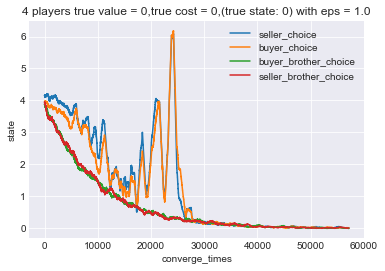

In [9]:
from matplotlib import pyplot as plt
ll = K.state_list.copy()

indexes1 = np.where(~np.isnan(K.state_list[0,:,0]))[0][-1] + 1

    
agree_ab_truth_list1 = np.full((indexes1),np.nan)
disagree_ab_truth_list1 = np.full((indexes1),np.nan)
agree_ab_lies_list1 = np.full((indexes1),np.nan)
disagree_ab_lies_list1 = np.full((indexes1),np.nan)
for i in range(indexes1):
#     if i%100000 ==0:
#         print(i)
    if i>=1000:
        buyer_list = ll[0,i-1000:i,0]
        buyer_brother_list = ll[0,i-1000:i,1]
        seller_list = ll[0,i-1000:i,2]
        seller_brother_list = ll[0,i-1000:i,3]

                              
        agree_ab_truth_list1[i-1000] = np.mean(buyer_list)
        disagree_ab_truth_list1[i-1000] = np.mean(buyer_brother_list)
        agree_ab_lies_list1[i-1000] = np.mean(seller_list)
        disagree_ab_lies_list1[i-1000] = np.mean(seller_brother_list)
        
plt.style.use('seaborn-darkgrid')
plt.plot(agree_ab_lies_list1)
plt.plot(agree_ab_truth_list1)
plt.plot(disagree_ab_lies_list1)
plt.plot(disagree_ab_truth_list1)
plt.legend(labels=['seller_choice','buyer_choice',\
                  'buyer_brother_choice','seller_brother_choice'],loc='best')
plt.xlabel('converge_times')
plt.ylabel('state')
plt.title('4 players true value = %d,true cost = %d,(true state: %d) with eps = %.1f'\
    %(K.game.true_value_index,K.game.true_cost_index,3*K.game.true_value_index+K.game.true_cost_index,1))